<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-rnn/blob/main/nlp_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4: Natural Disaster Tweets - RNN model

DTSA 5511 - Intro to Deep Learning
Link to GitHub repo: https://github.com/FleaBusyBeeBergs/dtsa5511-rnn.git

## 1. Introduction

###1.1 Description of the problem
The purpose of this project is to classify tweets as either a true natural disaster or not true natural disaster using a Recurrent Neural Network (RNN). RNNs are useful for sequential datasets, such as natural language processing. In natural language, the order in which words appear may change the meaning of the sentence. RNNs take this sequence into consideration by making a backwards pass over the data to update the model weights.

In [72]:
!pip install imbalanced-learn -q
!pip install tensorflow -q

In [57]:
!pip install keras-tuner -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [88]:
# general utilities
import os
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
import re
import nltk

from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls glove.6B.100d.txt

--2025-06-17 18:15:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-17 18:15:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-17 18:15:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zi

##2. EDA and cleaning

###2.1 The data

In [11]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# note to self: kaggle file is in dtsa5511 folder

Saving kaggle.json to kaggle.json


In [12]:
!kaggle competitions download -c nlp-getting-started -p /content/data > /dev/null
!unzip /content/data/nlp-getting-started -d ./data > /dev/null

100% 593k/593k [00:00<00:00, 1.16GB/s]


In [13]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

### 2.2 EDA & Cleaning

In [14]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The training dataset contains a little over 7,600 tweets, all with labels. The columns included are:
Numerical - id and target (bool)
Text objects - keyword, location, and text.
The data uses 297.5+ KB memory.
There are 61 records that are missing a keyword, and 2533 records missing a location. I'll add the keyword into the text column.

In [16]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
#df_train.loc[0:31,]

In [18]:
# add keyword into text column
df_train['keyword'] = df_train['keyword'].fillna('')
df_train['combined_text'] = df_train['keyword'] + ' ' + df_train['text']

In [19]:
df_train.head()

,id,keyword,location,text,target,combined_text
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as...


In [20]:
df_train = df_train.drop(columns = 'text')

In [21]:
df_train.rename(columns = {'combined_text': 'text'}, inplace = True)

In [22]:
df_train.head()

,id,keyword,location,target,text
0,1,,NaN,1,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,1,Forest fire near La Ronge Sask. Canada
2,5,,NaN,1,All residents asked to 'shelter in place' are...
3,6,,NaN,1,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,1,Just got sent this photo from Ruby #Alaska as...


In [23]:
df_train['keyword'].unique()


array(['', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'dera

###2.3 Visualization

target
0    0.57034
1    0.42966
Name: count, dtype: float64 



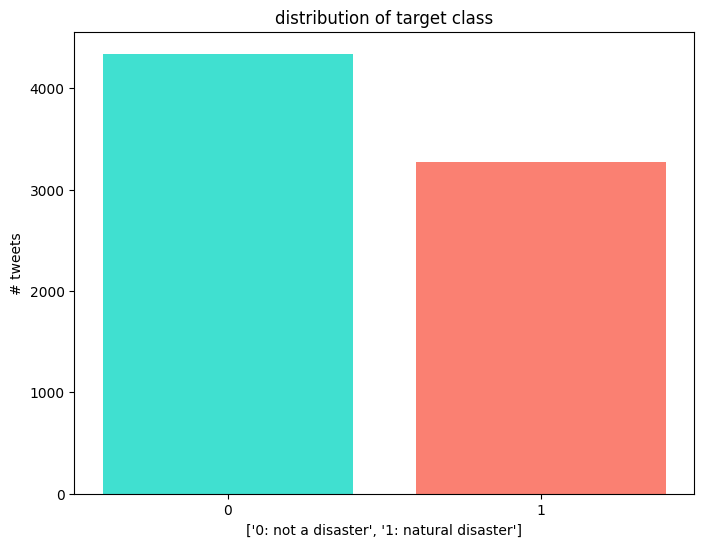

In [24]:
category_counts = df_train['target'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

# vis distribution
plt.figure(figsize = (8, 6))
plt.bar(category_counts.index,
        category_counts.values,
        color = ['turquoise', 'salmon'])
plt.xticks([0, 1])
plt.title('distribution of target class')
plt.xlabel(['0: not a disaster', '1: natural disaster'])
plt.ylabel('# tweets')
plt.show()

The classes are a little imbalanced. This will need to be dealt with for modelling.

### 2.4 Preprocessing data

In [25]:
# split data
X = df_train['text']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 5511)

In [26]:
# define functions to tokenize / embed text

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def preprocess_tweet(self, text):
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)

    def load_glove_embeddings(self, glove_path = 'glove.6B.100d.text'):
        embeddings_index = {}
        try:
            with open(glove_path, 'r', encoding = 'utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    vector = np.asarray(values[1:], dtype = 'float32')
                    embeddings_index[word] = vector
        except FileNotFoundError:
            print(f'glove file not found at {glove_path}.Please check file is in correct location')
            return None
        return embeddings_index

    def get_embedding_matrix(self, tokenizer, embedding_dim = 100, glove_path = 'glove.6B.100d.txt'):
        embeddings_index = self.load_glove_embeddings(glove_path)
        if embeddings_index is None:
            return None

        vocab_size = len(tokenizer.word_index) + 1
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix



In [27]:
# tokenize, preprocess
preprocessor = TextPreprocessor()

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(df_train['text'])

In [28]:
df_train['text'] = df_train['text'].apply(preprocessor.clean_text)
df_test['text'] = df_test['text'].apply(preprocessor.clean_text)

df_train['text'] = df_train['text'].apply(preprocessor.preprocess_tweet)
df_test['text'] = df_test['text'].apply(preprocessor.preprocess_tweet)

embedding_matrix = preprocessor.get_embedding_matrix(tokenizer)

In [29]:
# max seq lenght
max_seq_len = max([len(text.split()) for text in X_train])

In [30]:
# pad
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_sequences,
                               maxlen = max_seq_len,
                               padding = 'post',
                               truncating = 'post')
X_val_padded = pad_sequences(X_val_sequences,
                             maxlen = max_seq_len,
                             padding = 'post',
                             truncating = 'post')

Lets see what the top 10 words are for each target category.

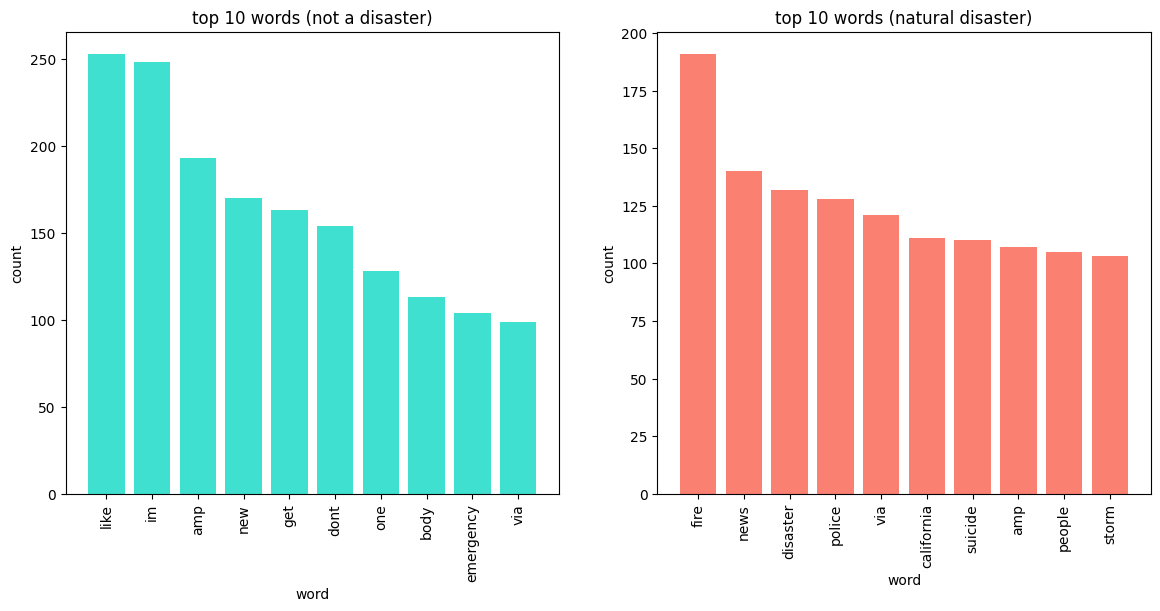

In [31]:
# top 10 words by category
word_count0 = pd.Series(' '.join(df_train[df_train['target'] == 0]['text']).split()).value_counts()
word_count1 = pd.Series(' '.join(df_train[df_train['target'] == 1]['text']).split()).value_counts()

#top 10
top0 = word_count0.head(10)
top1 = word_count1.head(10)

# plot
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
plt.bar(x = top0.index,
        height = top0.values,
         color = 'turquoise')
plt.title('top 10 words (not a disaster)')
plt.xlabel('word')
plt.ylabel('count')
plt.gca().tick_params(axis = 'x', rotation = 90)

plt.subplot(1, 2, 2)
plt.bar(x = top1.index,
        height = top1.values,
        color = 'salmon')
plt.title('top 10 words (natural disaster)')
plt.xlabel('word')
plt.ylabel('count')
plt.gca().tick_params(axis = 'x', rotation = 90)
plt.show()

In [32]:
# dealing with imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

class_weights = dict(enumerate(class_weights))

## 3. Modelling

To create an embedding layer, I'll use the Glove pre-trained. GloVe is short for Global Vectors for Word Representation and is an unsupervised algorithm to turn words that people understand into numbers that a machine will understand. It does this by using float integer vectors to represent the words of a text and mapping it to a dense vector. The angle and driection of the word vectors in the continuous vector space correspond to a semantic connection between words.

In [33]:
# define word embedding
embedding_layer = tf.keras.layers.Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1],
    weights = [embedding_matrix],
    #input_length = max_seq_len,
    trainable = False
)

### 3.1 Vanilla RNN architecture

I'll start with a very basic rnn architecture:
* First layer: GloVe embedding layer as described above
* Second layer: LSTM layer with 64 neurons
* Third layer: Fully connected layer using the sigmoid activation function and single output for bianry classification

In [34]:
# model1 - vanilla
model1 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [35]:
# model1 compile
model1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [36]:
# model1 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)

history = model1.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [37]:
history1 = pd.DataFrame(history.history)
history1.head()

,accuracy,loss,val_accuracy,val_loss
0,0.762069,0.509510,0.793828,0.474798
1,0.800164,0.439519,0.799737,0.457477
2,0.811987,0.421479,0.822062,0.433667
3,0.824466,0.409684,0.817466,0.433054
4,0.829228,0.390879,0.814183,0.432995


### 3.2 Stacked LSTM **architecture**

Next I'll add another layer to see if there is any improvement. This layer will be another LSTM layer with 32 neurons.

In [38]:
# add another layer

model2 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [39]:
model2.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [40]:
# model2 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history2 = model2.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [41]:
history2 = pd.DataFrame(history2.history)
history2

,accuracy,loss,val_accuracy,val_loss
0,0.764860,0.510909,0.785949,0.487475
1,0.799672,0.441474,0.814183,0.438272
2,0.814450,0.426008,0.816152,0.442143
3,0.823810,0.402894,0.794485,0.477280
4,0.832677,0.392799,0.808930,0.433665
5,0.840066,0.381604,0.808273,0.465296
6,0.842036,0.371386,0.821405,0.458036
7,0.851067,0.357299,0.799737,0.443847


### 3.3 Bidirectional LSTM architecture

Let's add a bidirectional layer to allow the model to learn from both the past and the future by taking context from the previous information in the series with a backwards pass as well as a forward pass.

In [42]:
# bidirectional layer
model3 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [43]:
model3.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [44]:
# model3 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history3 = model3.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [45]:
history3 = pd.DataFrame(history3.history)
history3

,accuracy,loss,val_accuracy,val_loss
0,0.771593,0.482537,0.805647,0.444463
1,0.812972,0.419585,0.799081,0.461622
2,0.821346,0.400347,0.798424,0.460205
3,0.830542,0.382721,0.814183,0.430201
4,0.838424,0.366498,0.806960,0.467474
5,0.848768,0.351511,0.816152,0.445578
6,0.858292,0.330733,0.812869,0.457241


### Bi-directional LSTM with drop-out

And now lets add a drop out layer to prevent over fitting. The dropout layer does this by randomly turning off a fraction of the neurons in the layer durning each training step.

In [46]:
model4 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [47]:
model4.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [48]:
# model4 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history4 = model4.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [49]:
history4 = pd.DataFrame(history4.history)
history4

,accuracy,loss,val_accuracy,val_loss
0,0.735140,0.536396,0.799081,0.456074
1,0.794746,0.455113,0.804334,0.456948
2,0.802956,0.438487,0.802364,0.458200
3,0.807553,0.427156,0.816809,0.444170
4,0.816585,0.414597,0.816809,0.442692
5,0.814121,0.412738,0.823375,0.440988
6,0.822496,0.408205,0.812213,0.435684
7,0.831363,0.390674,0.818779,0.439323
8,0.825287,0.390433,0.824688,0.447466
9,0.830706,0.386402,0.826658,0.430343


In [74]:
results_data = {
    'model': ['model1', 'model2', 'model3', 'model4'],
    'best_validation_accuracy': [
        history1['val_accuracy'].max(),
        history2['val_accuracy'].max(),
        history3['val_accuracy'].max(),
        history4['val_accuracy'].max()
    ],
    'corresponding_validation_loss': [
        history1['val_loss'][history1['val_accuracy'].idxmax()],
        history2['val_loss'][history2['val_accuracy'].idxmax()],
        history3['val_loss'][history3['val_accuracy'].idxmax()],
        history4['val_loss'][history4['val_accuracy'].idxmax()]
    ],
    'number_of_epochs': [
        history1['val_accuracy'].idxmax() + 1,
        history2['val_accuracy'].idxmax() + 1,
        history3['val_accuracy'].idxmax() + 1,
        history4['val_accuracy'].idxmax() + 1
    ]
}

results_df = pd.DataFrame(results_data)
results_df

,model,best_validation_accuracy,corresponding_validation_loss,number_of_epochs
0,model1,0.822062,0.433667,3
1,model2,0.821405,0.458036,7
2,model3,0.816152,0.445578,6
3,model4,0.826658,0.430343,10


Looking at the results_df of the different models tried, it appears that all 4 of the models performed reasonable well on the training data. Model4 had a the highest validation accuracy of 0.8267 and lowest validation loss of 0.4303. Model4 will be selected for hyperparameter tuning.


### 3.5 Hyperparameter tuning - bi-directional LSTM with dropout

In [75]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(embedding_layer)
  model.add(tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(
          hp.Int('lstm_units', 32, 64, step = 32),
          dropout = 0.2, # i chose to fix this hp to speed up the process of tuning.
          recurrent_dropout = 0.2) # also chose to fix this one
  ))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

In [60]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy',
                        max_trials = 5,
                        directory = 'tune_dir',
                        project_name = 'rnn natural_disaster_tweets')

tuner.search(X_train_padded,
             y_train,
             epochs = 3,
             validation_data = (X_val_padded, y_val),
             verbose = 0,
             callbacks = [early_stopping])

Reloading Tuner from tune_dir/rnn natural_disaster_tweets/tuner0.json


In [79]:
# results
tuner.results_summary()
best_model = tuner.get_best_models(num_models = 1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
print('best architectre:')
best_model.summary()
print('\n best hp:')
best_hp.values

Results summary
Results in tune_dir/rnn natural_disaster_tweets
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
lstm_units: 64
Score: 0.8141825199127197

Trial 00 summary
Hyperparameters:
lstm_units: 32
Score: 0.8069599270820618
best architectre:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 100)        │     2,273,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,357,709 (8.99 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 2,273,100 (8.67 MB)


 best hp:


{'lstm_units': 64}

In [81]:
# predict
y_pred_probs = best_model.predict(X_train_padded)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


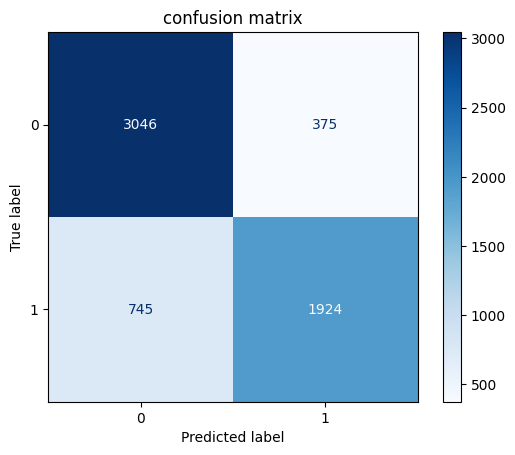

In [86]:
# plot conf matrix
conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                              display_labels = [0,1])
disp.plot(cmap = plt.cm.Blues)
plt.title('confusion matrix')
plt.show()

In [90]:
# class. report
report = classification_report(y_train,
                               y_pred,
                               target_names = ['not a disaster', 'natural disaster'])
print(report)

                  precision    recall  f1-score   support

  not a disaster       0.80      0.89      0.84      3421
natural disaster       0.84      0.72      0.77      2669

        accuracy                           0.82      6090
       macro avg       0.82      0.81      0.81      6090
    weighted avg       0.82      0.82      0.81      6090



## 4. Results and Analysis


### 4.1 Model testing

It's time to test out the model! Let's see how it performs on unseen data.

In [63]:
# prep full taining data
X_full = df_train['text'].apply(preprocessor.clean_text)
X_full = X_full.apply(preprocessor.preprocess_tweet)
y_full = df_train['target']

X_full_sequences = tokenizer.texts_to_sequences(X_full)
X_full_padded = pad_sequences(X_full_sequences,
                              maxlen = max_seq_len,
                              padding = 'post',
                              truncating = 'post')



In [64]:
# prep test data
X_test = df_test['text'].apply(preprocessor.clean_text)
X_test = X_test.apply(preprocessor.preprocess_tweet)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,
                              maxlen = max_seq_len,
                              padding = 'post',
                              truncating = 'post')

In [65]:
# build model

clear_session()

# best hyperparameters from above tuner
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
print('best hp: {best_hp.values}')

best_model = build_model(best_hp)

early_stopping_final = EarlyStopping(monitor = 'loss',
                                     patience = 5)

best hp: {best_hp.values}


In [66]:
# fit model
best_model.fit(X_full_padded,
               y_full,
               epochs = 20,
               verbose = 1,
               callbacks = [early_stopping_final])

Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.7232 - loss: 0.5539
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.7938 - loss: 0.4623
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.8010 - loss: 0.4488
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.8014 - loss: 0.4452
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8086 - loss: 0.4325
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8078 - loss: 0.4290
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8205 - loss: 0.4091
Epoch 8/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.8326 - loss: 0.3971
Epoch 9/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8312 - loss: 0.3821
Epoch 10/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8389 - loss: 0.3817
Epoch 11/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8330 - loss: 0.3827
Epoch 12/20
238/238 ━━━━━━━━━━

In [67]:
# predict test data to binary
predictions = best_model.predict(X_test_padded)
predictions = (predictions > 0.5).astype(int)

# make submission file
sub_df = pd.DataFrame({'id': df_test['id'],
                       'target': predictions.flatten()})
sub_df.to_csv('rnn_submission.csv', index = False)

sub_df.head(10)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [71]:
# download file
files.download('rnn_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

_submission score: 0.79558!_

### 4.2 Discussion

I began this project with some brief eda, followed by handling the natural language processing of the tweets. Text was cleaned and preprocessed by converting text to all lowercase, removing URLs, non-alphabetic characters, and white space, removing stop-words, and combining the keyword and text columns. The text was then tokenized with Keras to convert the text into integer sequences, which were based on the frequency of the training data. The last step was padding to ensure that all sequences were of the same length.



My chosen model using bir-directional LSTM with drop out was the best performing out of the different architectures tried. On the training data, model4 had:
* training accuracy of 0.8307
* validation accuracy of 0.8267
* training loss of 0.3864
* validation loss of 0.4303
* testing accuracy of 0.79558

There was a very slight decrease in accuracy of the model between the training and validation sets, indicating that the model was not overfitting at that stage. I chose to limit the hyperparameters to tune to just lstm_units because the tuning process was taking a very long time and I have limited GPU usage. After tuning, the best hyperparameter for lstm_units was 64, resulting in an accuracy score of 0.8142. A confusion matrix and classification report were created to better visualize the results.

Upon submission of the predictions to the Kaggle competition, I received a score of 0.79558. This was another small drop in the accuracy between the full training and testing data, indicating that the model was a little overfit but overall decent performance!

There is definitely room for improvement:
* play around with more stacking within the bidirecrtional LSTM with dropout
* tuning more hyperparameters (was limited by GPU availability). Dropout may have addressed some of the overfitting issue.

## 5. Conclusion

In this project, I cleaned then preprocessed the natural disaster tweet from a Kaggle competition using the GloVe embedding. I then tried out a few different RNN architectures for binary classification of the tweets as either a true natural disaster or not a natural disaster. The bi-directional LSTM with a dropout was the best performing model. I tuned the LSTM units and found that 64 was the best. I would have tuned additional hyperparameters, but I am limited in GPU useage. Upon predicting on the testing tweets, I submitted my results to the Kaggle competition for a score of 0.79558.

## 6. References


1. GloVe word embedding:
https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/
2. All DTSA5511 course lectures, notes, and assignments
3. OpenAI - yup, I used it as a tool, NOT to do the work for me.